<a href="https://colab.research.google.com/github/PrinceV-hub/IMU-GPS-Visualizer/blob/main/fraud_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fraud Assignment 4**

Topic-GAN Generation of Synthetic Data

PRINCE VERMA-SM24MTECH11003

NAGARJUNA POLISETTI-SM24MTECH14009

Importing important files


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.plotting as pd_plotting
import io

Dataset loading

In [4]:
# === Load and preprocess data ===
df = pd.read_excel("data.xlsx", sheet_name=0)  # Adjust sheet_name if needed
data = df.select_dtypes(include=[np.number])  # Use numeric columns only
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [9]:
df.head()

,cov1,cov2,cov3,cov4,cov5,cov6,cov7,sal_pur_rat,igst_itc_tot_itc_rat,lib_igst_itc_rat
0,0.997797,0.999888,0.215934,0.196713,0.000000,0.955616,0.998810,-0.032581,1.761759,-0.054329
1,0.994004,0.979902,-0.337135,-0.248634,0.000000,0.640812,0.553918,-0.032026,-0.629311,-0.053516
2,0.947603,0.455667,0.001743,0.128610,-0.004054,-0.162069,0.960601,-0.030209,1.535697,-0.054215
3,0.396577,0.919933,0.496451,0.576824,-0.340718,0.802363,0.673710,-0.032058,0.449160,-0.054126
4,0.999893,0.327615,0.700477,0.315601,0.000000,0.300785,0.979009,-0.032224,1.762049,-0.054330


In [13]:
row , columns = df.shape
print(f"Number of rows:{row} and number of columns is :{columns}")

Number of rows:1199 and number of columns is :10


Generator and Discriminator class

In [5]:
# === Define Generator and Discriminator ===
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [6]:

# === Initialize models ===
latent_dim = 20
data_dim = data_scaled.shape[1]
generator = Generator(latent_dim, data_dim)
discriminator = Discriminator(data_dim)

# === Loss and Optimizer ===
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)


Training

Epoch 0 | D Loss: 1.3275 | G Loss: 0.8267
Epoch 500 | D Loss: 1.1885 | G Loss: 0.8625
Epoch 1000 | D Loss: 1.3466 | G Loss: 0.6843
Epoch 1500 | D Loss: 1.3700 | G Loss: 0.8168
Epoch 2000 | D Loss: 1.2902 | G Loss: 0.7221
Epoch 2500 | D Loss: 1.3846 | G Loss: 0.7272
Epoch 3000 | D Loss: 1.2764 | G Loss: 0.7589
Epoch 3500 | D Loss: 1.3444 | G Loss: 0.7375
Epoch 4000 | D Loss: 1.3906 | G Loss: 0.7845
Epoch 4500 | D Loss: 1.4149 | G Loss: 0.7257


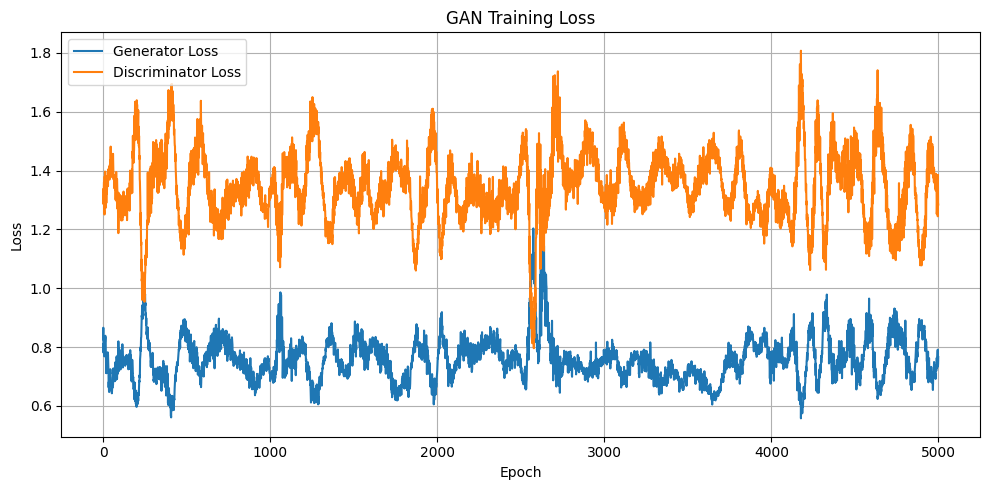

In [14]:
# === Training ===
epochs = 5000
batch_size = 64
real_label = 1.
fake_label = 0.

g_losses = []
d_losses = []

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, data_scaled.shape[0], batch_size)
    real_data = torch.tensor(data_scaled[idx], dtype=torch.float)
    noise = torch.randn(batch_size, latent_dim)
    fake_data = generator(noise)

    optimizer_D.zero_grad()
    loss_real = criterion(discriminator(real_data), torch.full((batch_size, 1), real_label))
    loss_fake = criterion(discriminator(fake_data.detach()), torch.full((batch_size, 1), fake_label))
    loss_D = loss_real + loss_fake
    loss_D.backward()
    optimizer_D.step()

    # Train Generator
    optimizer_G.zero_grad()
    loss_G = criterion(discriminator(fake_data), torch.full((batch_size, 1), real_label))
    loss_G.backward()
    optimizer_G.step()

    # Save losses
    g_losses.append(loss_G.item())
    d_losses.append(loss_D.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

# === Plot Loss Curves ===
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gan_loss_plot.png")
plt.show()


Generate Synthetic Data from Trained Generator

In [8]:
# === Generate synthetic data ===
noise = torch.randn(data_scaled.shape[0], latent_dim)
synthetic_data = generator(noise).detach().numpy()
synthetic_data = scaler.inverse_transform(synthetic_data)
synthetic_df = pd.DataFrame(synthetic_data, columns=data.columns)
synthetic_df.to_csv("synthetic_data.csv", index=False)
print("Synthetic data saved to synthetic_data.csv")

Synthetic data saved to synthetic_data.csv


Check Synthetic Data Shape and Sample

In [15]:
# Show shape and first few rows
print("\nSynthetic Data Shape:", synthetic_df.shape)
print("\nColumn Names:\n", synthetic_df.columns.tolist())
print("\nFirst 5 Rows:\n", synthetic_df.head())



Synthetic Data Shape: (1199, 10)

Column Names:
 ['cov1', 'cov2', 'cov3', 'cov4', 'cov5', 'cov6', 'cov7', 'sal_pur_rat', 'igst_itc_tot_itc_rat', 'lib_igst_itc_rat']

First 5 Rows:
        cov1      cov2      cov3      cov4      cov5      cov6      cov7  \
0  0.998133  0.976887 -0.212938 -0.360999  0.443496  0.930094  0.167841   
1  0.997786  0.982465  0.539910  0.677018  0.654798  0.838753  0.919109   
2  0.981023  0.907587  0.546920  0.452396  0.422975  0.626348  0.119121   
3  0.991763  0.953492  0.778846  0.757999  0.550595  0.613032  0.508647   
4  0.922821  0.825473  0.297628  0.298889  0.347535  0.585844  0.468377   

   sal_pur_rat  igst_itc_tot_itc_rat  lib_igst_itc_rat  
0    -0.035293             -0.987069         -0.054404  
1    -0.035306              1.529582         -0.054417  
2    -0.033694             -0.847005         -0.051471  
3    -0.035207             -0.256450         -0.054167  
4     0.002795              0.353925          0.005819  


Pearson correlation & Heatmap


 Compare Real vs Synthetic Data


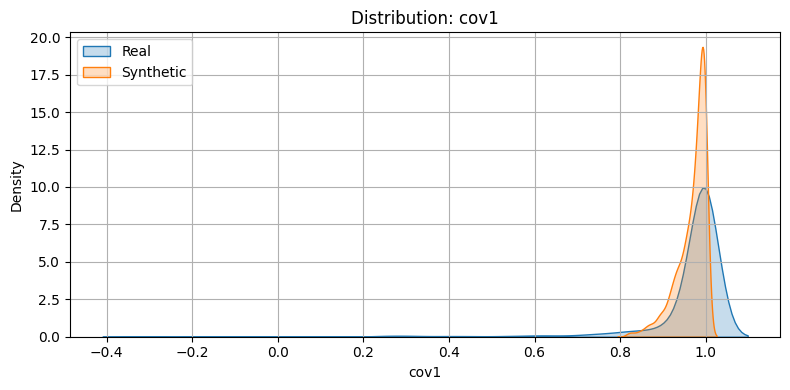

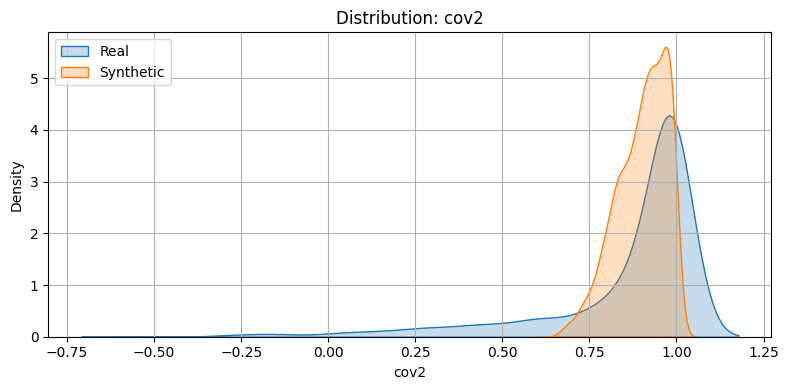

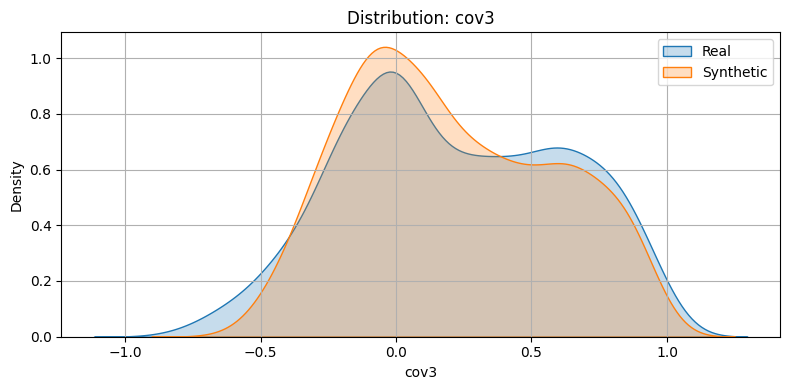

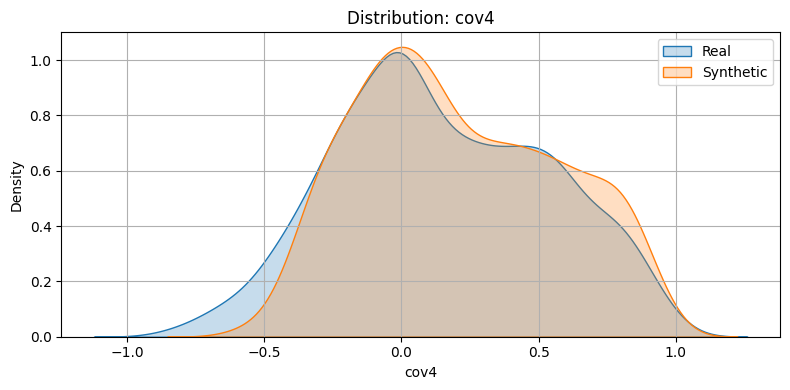

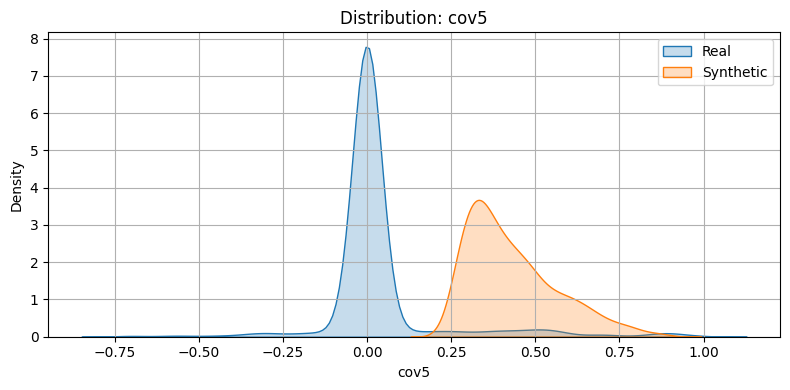

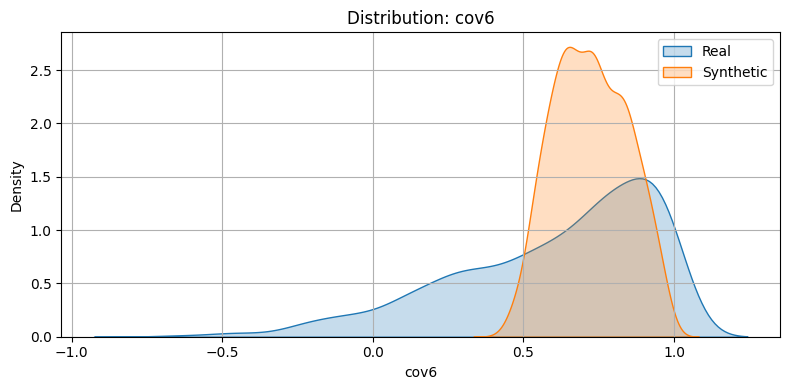

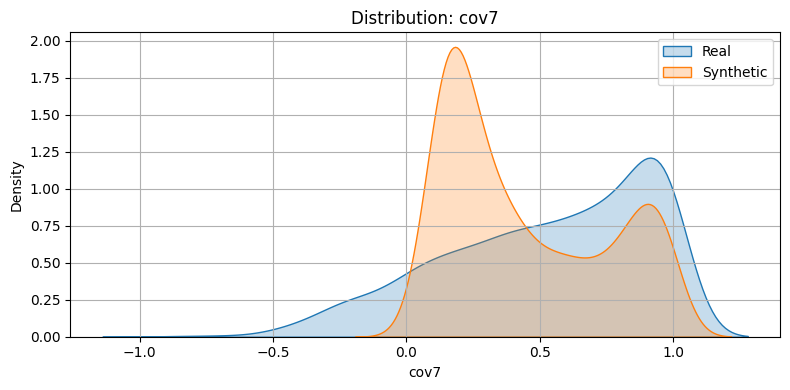

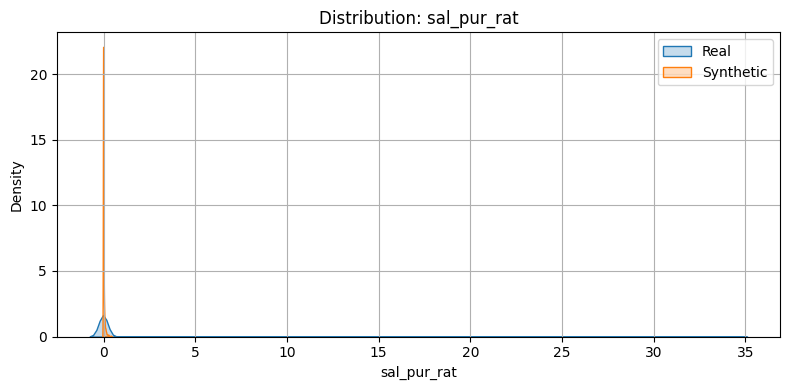

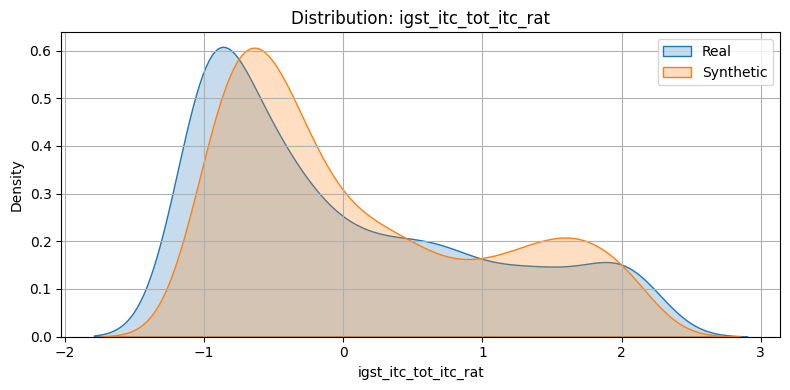

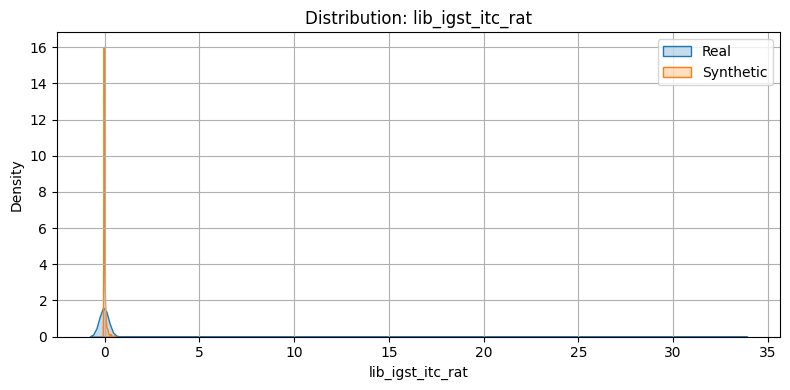

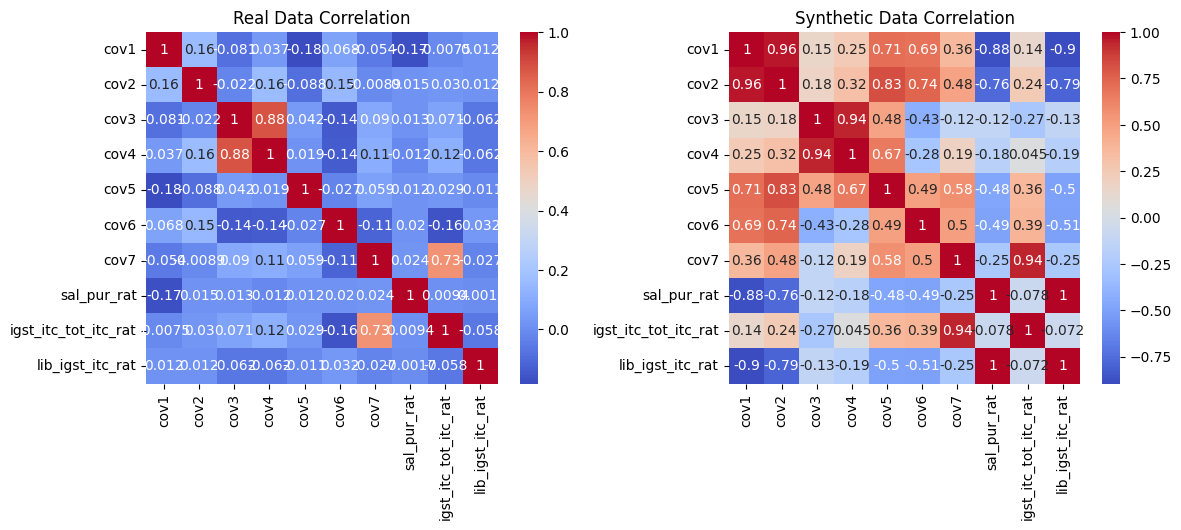

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load real and synthetic data
real_df = pd.DataFrame(data, columns=data.columns)
synthetic_df = pd.read_csv("synthetic_data.csv")

# === 1. Plot feature distributions ===
for column in real_df.columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(real_df[column], label='Real', fill=True)
    sns.kdeplot(synthetic_df[column], label='Synthetic', fill=True)
    plt.title(f"Distribution: {column}")
    plt.xlabel(column)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === 2. Pearson Correlation Matrices ===
real_corr = real_df.corr(method='pearson')
synthetic_corr = synthetic_df.corr(method='pearson')

# === 3. Heatmap comparison ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(real_corr, annot=True, cmap='coolwarm', square=True)
plt.title("Real Data Correlation")

plt.subplot(1, 2, 2)
sns.heatmap(synthetic_corr, annot=True, cmap='coolwarm', square=True)
plt.title("Synthetic Data Correlation")

plt.tight_layout()
plt.show()
